In [1]:
from __future__ import print_function, division
from builtins import range

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [3]:
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

In [4]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [5]:
# load in pre-tained word vectors
print("Loading word vectors...")
word2vec = {}
with open(os.path.join('data/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [6]:
# prepare the text smaples and their labels
print('Loading in comments...')

train = pd.read_csv('data/train.csv')
sentences = train['comment_text'].fillna('DUMMY_VALUE').values
possible_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
targets = train[possible_labels].values

Loading in comments...


In [7]:
# convert the sentences into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [8]:
print('max sequence length: ', max(len(s) for s in sentences))
print('min sequence length: ', min(len(s) for s in sentences))
s = sorted(len(s) for s in sequences)
print('median sequence length: ', s[len(s) // 2])
print('max word index: ', max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length:  5000
min sequence length:  6
median sequence length:  35
max word index:  19999


In [9]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [10]:
# pad sequence so that we get N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor: ', data.shape)

Shape of data tensor:  (159571, 100)


In [11]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) +1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [12]:
from sklearn.model_selection import train_test_split    
from sklearn.preprocessing import MinMaxScaler

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=VALIDATION_SPLIT, random_state=101)

In [14]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [15]:
print('Building model...')
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

Building model...


In [16]:
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [17]:
print('Training model...')
r = model.fit(
    X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test)
)

Training model...
Epoch 1/10
998/998 [==============================] - 103s 103ms/step - loss: 0.0847 - accuracy: 0.9713 - val_loss: 0.0706 - val_accuracy: 0.9940
Epoch 2/10
998/998 [==============================] - 108s 108ms/step - loss: 0.0678 - accuracy: 0.9902 - val_loss: 0.0822 - val_accuracy: 0.9940
Epoch 3/10
998/998 [==============================] - 106s 107ms/step - loss: 0.0635 - accuracy: 0.9916 - val_loss: 0.0815 - val_accuracy: 0.9932
Epoch 4/10
998/998 [==============================] - 109s 109ms/step - loss: 0.0601 - accuracy: 0.9929 - val_loss: 0.0679 - val_accuracy: 0.9938
Epoch 5/10
998/998 [==============================] - 109s 109ms/step - loss: 0.0576 - accuracy: 0.9937 - val_loss: 0.0745 - val_accuracy: 0.9939
Epoch 6/10
998/998 [==============================] - 110s 110ms/step - loss: 0.0557 - accuracy: 0.9935 - val_loss: 0.0749 - val_accuracy: 0.9937
Epoch 7/10
998/998 [==============================] - 118s 118ms/step - loss: 0.0542 - accuracy: 0.9932 - 

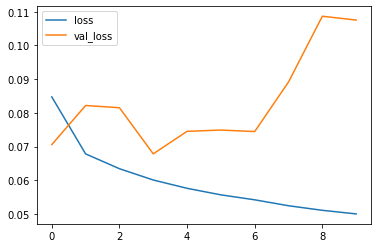

In [18]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

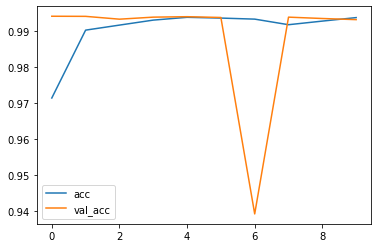

In [19]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [20]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9764117677097476


In [21]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

In [22]:
probability = model.predict(X_test)

In [23]:
thresh = 0.5
predictions = np.array([[1 if i > thresh else 0 for i in j] for j in probability])

In [24]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.60      0.69      3087
           1       0.53      0.22      0.31       320
           2       0.75      0.69      0.72      1720
           3       0.25      0.02      0.04       104
           4       0.72      0.52      0.61      1580
           5       0.61      0.15      0.24       275

   micro avg       0.77      0.56      0.65      7086
   macro avg       0.61      0.37      0.43      7086
weighted avg       0.75      0.56      0.64      7086
 samples avg       0.05      0.05      0.05      7086



/home/ahsan/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ahsan/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
